In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

# !pip install --quiet shap==0.39.0
import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

F:\Anaconda\envs\conda\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [2]:
df_rta = pd.read_csv("RTA_Dataset.csv")

In [3]:
df_rta

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,Male,NaN,Employee,2-5yr,Lorry (11?40Q),Owner,NaN,No defect,Outside rural areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Going straight,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12312,18:00:00,Sunday,Unknown,Male,Elementary school,Employee,5-10yr,Automobile,Owner,NaN,No defect,Outside rural areas,Two-way (divided with broken lines road marking),Escarpments,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12313,13:55:00,Sunday,Over 51,Male,Junior high school,Employee,5-10yr,Bajaj,Owner,2-5yrs,No defect,Outside rural areas,Two-way (divided with broken lines road marking),Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,1,1,Other,Driver or rider,Male,31-50,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury
12314,13:55:00,Sunday,18-30,Female,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,No defect,Office areas,Undivided Two way,Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury


## Exploratory Data Analysis

In [4]:
df_rta.shape

(12316, 32)

In [5]:
df_rta.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [6]:
## Renaming the columns 

col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df_rta.rename(columns=col_map, inplace=True)

In [7]:
## Converting time to datetime

df_rta["time"] = pd.to_datetime(df_rta["time"])

In [8]:
df_rta.describe(include=['O']).T

,count,unique,top,freq
day_of_week,12316,7,Friday,2041
driver_age,12316,5,18-30,4271
driver_sex,12316,3,Male,11437
educational_level,11575,7,Junior high school,7619
vehicle_driver_relation,11737,4,Employee,9627
driving_experience,11487,7,5-10yr,3363
vehicle_type,11366,17,Automobile,3205
vehicle_owner,11834,4,Owner,10459
service_year,8388,6,Unknown,2883
vehicle_defect,7889,3,No defect,7777


In [9]:
## Checking the percentage of the null values in the dataframe

percent_missing_values = df_rta.isnull().sum() * 100/len(df_rta)
missing_values = pd.DataFrame({'column_name' : df_rta.columns, 'percent_missing' : percent_missing_values})

In [10]:
missing_values

,column_name,percent_missing
time,time,0.000000
day_of_week,day_of_week,0.000000
driver_age,driver_age,0.000000
driver_sex,driver_sex,0.000000
educational_level,educational_level,6.016564
vehicle_driver_relation,vehicle_driver_relation,4.701202
driving_experience,driving_experience,6.731082
vehicle_type,vehicle_type,7.713543
vehicle_owner,vehicle_owner,3.913608
service_year,service_year,31.893472


#### This has to be brought to notice that casualty_work, casualty_fitness, service_year and vehicle_defect are having more than 20% of null values

In [11]:
df_rta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     12316 non-null  datetime64[ns]
 1   day_of_week              12316 non-null  object        
 2   driver_age               12316 non-null  object        
 3   driver_sex               12316 non-null  object        
 4   educational_level        11575 non-null  object        
 5   vehicle_driver_relation  11737 non-null  object        
 6   driving_experience       11487 non-null  object        
 7   vehicle_type             11366 non-null  object        
 8   vehicle_owner            11834 non-null  object        
 9   service_year             8388 non-null   object        
 10  vehicle_defect           7889 non-null   object        
 11  accident_area            12077 non-null  object        
 12  lanes                    11931 n

In [12]:
print("The Number of duplicates are : ", df_rta.duplicated().sum())
print("The number of unique values :")
df_rta.nunique()

The Number of duplicates are :  0
The number of unique values :


time                       1074
day_of_week                   7
driver_age                    5
driver_sex                    3
educational_level             7
vehicle_driver_relation       4
driving_experience            7
vehicle_type                 17
vehicle_owner                 4
service_year                  6
vehicle_defect                3
accident_area                14
lanes                         7
road_allignment               9
junction_type                 8
surface_type                  5
road_surface_conditions       4
light_condition               4
weather_condition             9
collision_type               10
vehicles_involved             6
casualties                    8
vehicle_movement             13
casualty_class                4
casualty_sex                  3
casualty_age                  6
casualty_severity             4
casualty_work                 7
casualty_fitness              5
pedestrian_movement           9
accident_cause               20
accident

In [13]:
## Extracting the hours and the minutes from the timestamp

df_rta["hour"] = df_rta["time"].dt.hour
df_rta["minute"] = df_rta["time"].dt.minute
df_rta.drop("time", inplace=True, axis = 1)

In [14]:
df_rta.head()

,day_of_week,driver_age,driver_sex,educational_level,vehicle_driver_relation,driving_experience,vehicle_type,vehicle_owner,service_year,vehicle_defect,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_work,casualty_fitness,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17,2
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17,2
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17,2
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1,6
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1,6


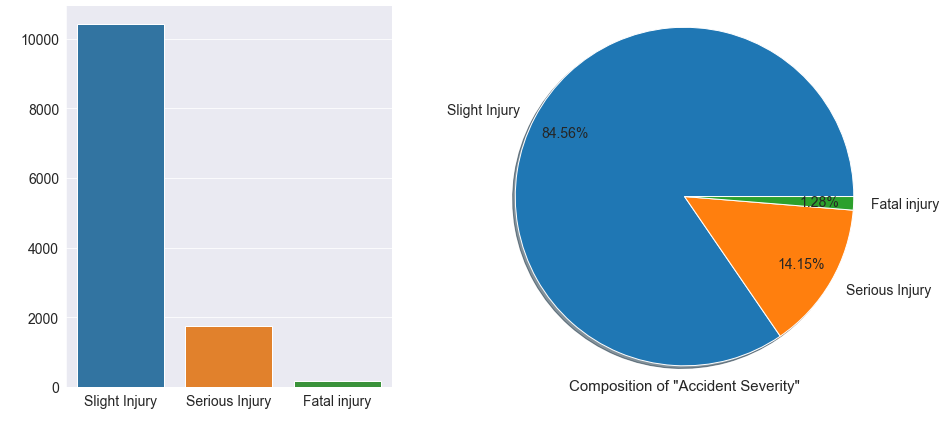

In [16]:
## Checking the target value using the grpah

plt.figure(figsize=(14,7))
##barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x = df_rta["accident_severity"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

sns.despine(top=True, right=True)

# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df_rta["accident_severity"].value_counts(),
        labels=list(df_rta["accident_severity"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Accident Severity"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)

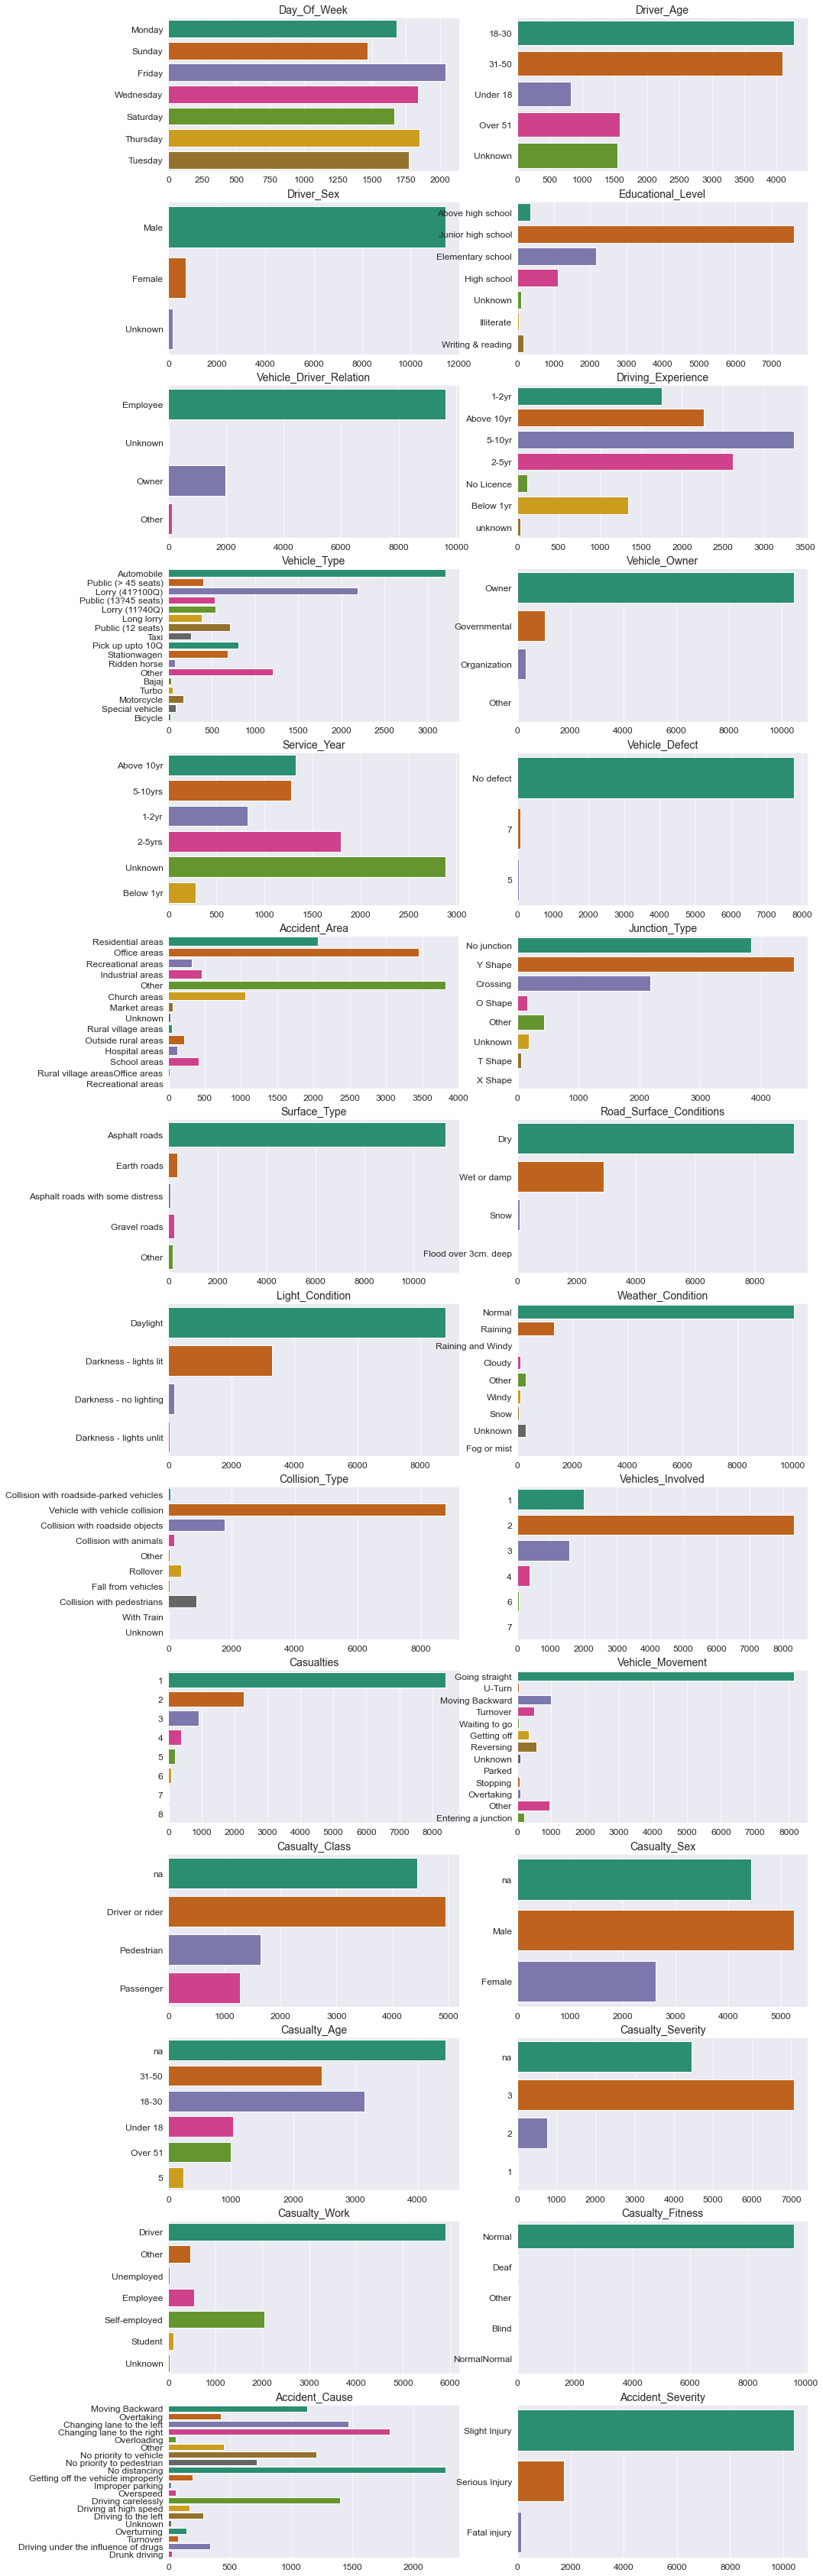

In [17]:
## Now check for the plots for all the columns 

plt.figure(figsize=(15,70))

plotnumber = 1

for col in df_rta.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'],axis=1):
    if plotnumber <= df_rta.shape[1]:
        ax1 = plt.subplot(16,2, plotnumber)
        sns.countplot(data=df_rta, y = col, palette="Dark2")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.show()
        

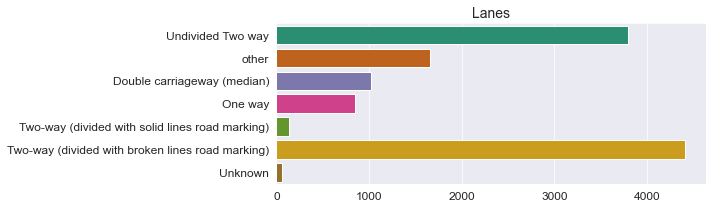

In [18]:
## Considering the columns 'hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement' and checking the rate at which the accident took place
## For lanes 

plt.figure(figsize=(10,3))
sns.countplot(data=df_rta, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

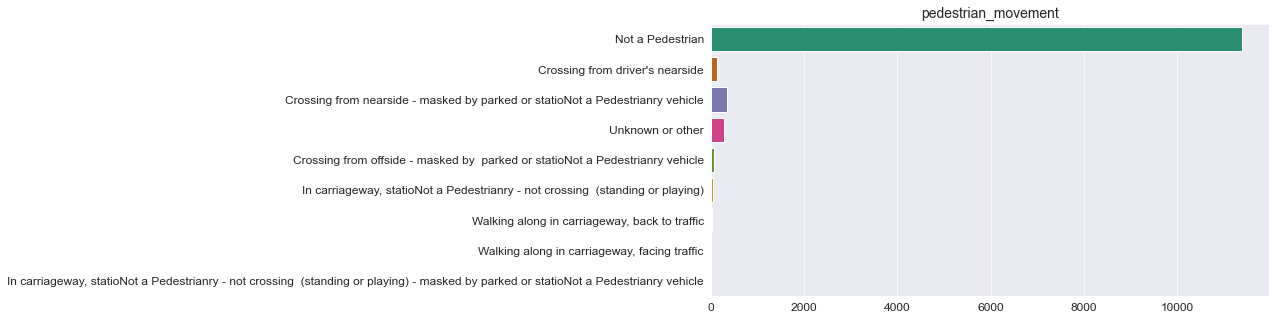

In [19]:
## For pedestrian_movement
plt.figure(figsize=(10,5))
sns.countplot(data=df_rta, y = "pedestrian_movement", palette="Dark2")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("pedestrian_movement", fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

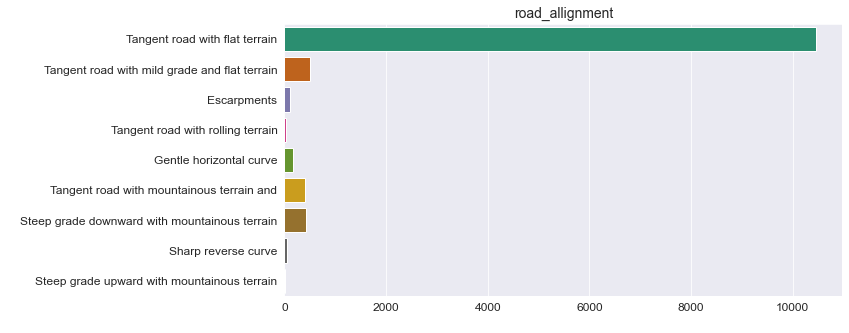

In [20]:
## For road_allignment

plt.figure(figsize=(10,5))
sns.countplot(data = df_rta, y = 'road_allignment', palette="Dark2")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("road_allignment", fontsize=14)
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

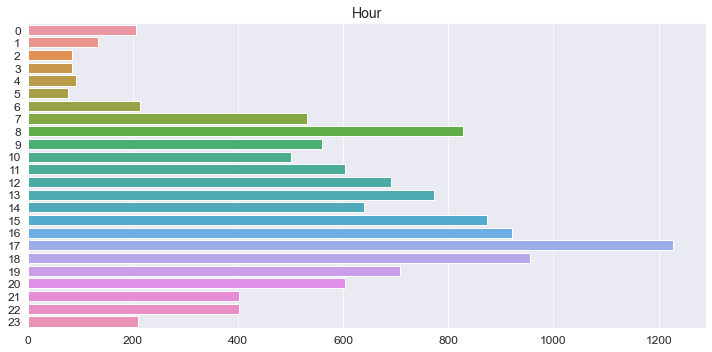

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_rta, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

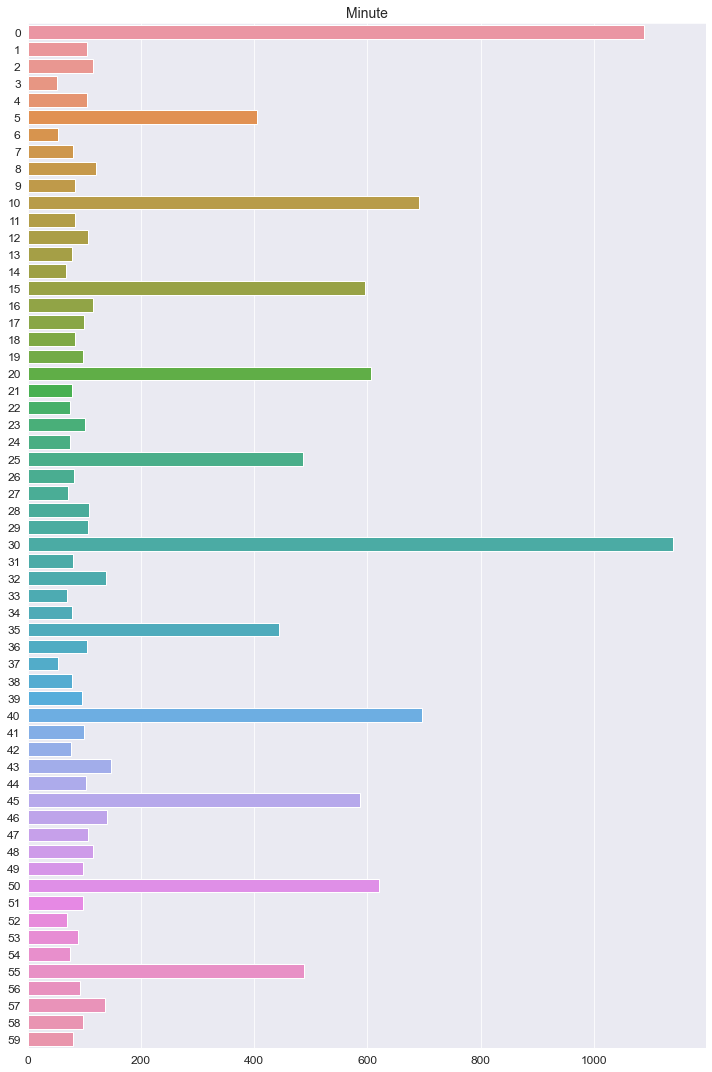

In [22]:
plt.figure(figsize=(10,15))
sns.countplot(data=df_rta, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [23]:
##Seggregating the numerical and the categorical columns

num_cols = df_rta.dtypes[df_rta.dtypes == 'int64'].index.tolist()
cat_cols = df_rta.dtypes[df_rta.dtypes != 'int64'].index.tolist()
df_rta[cat_cols].head()

,day_of_week,driver_age,driver_sex,educational_level,vehicle_driver_relation,driving_experience,vehicle_type,vehicle_owner,service_year,vehicle_defect,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_work,casualty_fitness,pedestrian_movement,accident_cause,accident_severity
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [24]:
df_rta[num_cols].head()

,vehicles_involved,casualties,hour,minute
0,2,2,17,2
1,2,2,17,2
2,2,2,17,2
3,2,2,1,6
4,2,2,1,6


In [25]:
df_rta.isnull().sum()


day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident_severity             0
hour    

### Preprocessing the data

In [26]:
df_rta.isna().sum()[df_rta.isna().sum() != 0]

educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
collision_type              155
vehicle_movement            308
casualty_work              3198
casualty_fitness           2635
dtype: int64

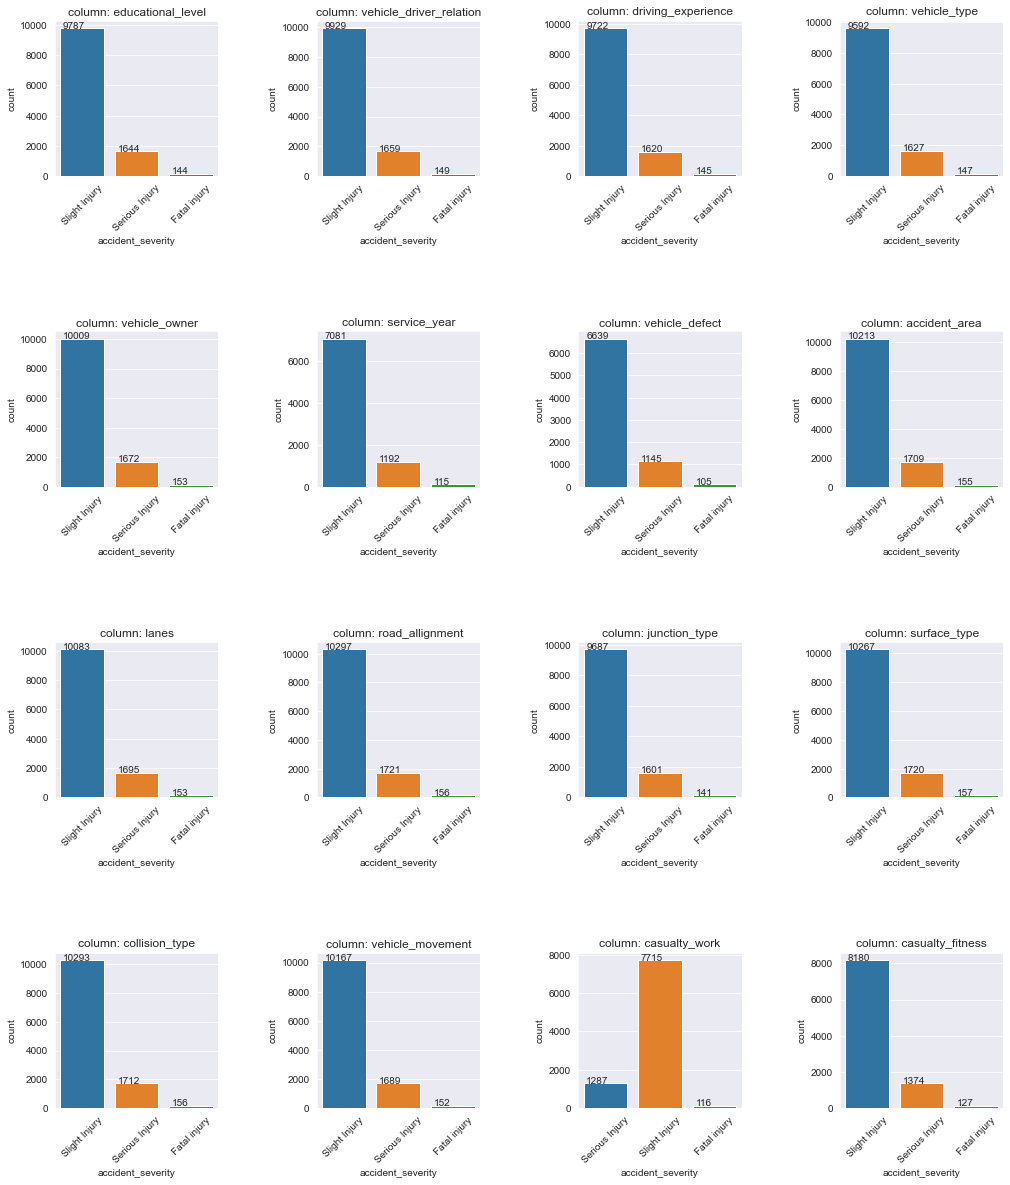

In [27]:
fig = plt.figure(figsize = (17,20))
fig.subplots_adjust(hspace=1, wspace=0.6)

cols = df_rta.isna().sum()[df_rta.isna().sum() != 0].index.tolist()
for i,col in enumerate(cols):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    sns.countplot(x=df_rta.dropna(subset=[col])["accident_severity"])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))
    ax.set_title('column: ' + str(col))
plt.show()

In [28]:
## Dropping the columns which can cause imbalance during the imputation
df_rta.drop(columns= ['vehicle_defect', 'vehicle_driver_relation', 'casualty_work'], inplace=True)

In [29]:
impute_cols = [x for x in df_rta.isna().sum()[df_rta.isna().sum() != 0].index.to_list()]
for feat in impute_cols:
    mode = df_rta[feat].mode()[0]
    df_rta[feat].fillna(mode, inplace = True)

In [30]:
df_rta.isna().sum()

day_of_week                0
driver_age                 0
driver_sex                 0
educational_level          0
driving_experience         0
vehicle_type               0
vehicle_owner              0
service_year               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
surface_type               0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_sex               0
casualty_age               0
casualty_severity          0
casualty_fitness           0
pedestrian_movement        0
accident_cause             0
accident_severity          0
hour                       0
minute                     0
dtype: int64

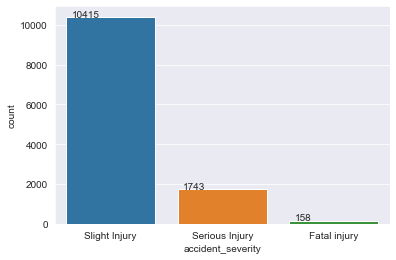

In [31]:
ax = sns.countplot(x=df_rta["accident_severity"])
for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))

plt.show()

In [32]:
## Forward filling the values where Nulls are available.

## df_rta = df_rta.ffill()

In [33]:
## Performing the encoding 

def ordinal_encoder(df_rta,feats): 
    for feat in feats:    
        feat_val = list(1+np.arange(df_rta[feat].nunique()))
        feat_key = list(df_rta[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
    df_rta[feat] = df_rta[feat].map(feat_dict)   
    return df_rta

df_rta = ordinal_encoder(df_rta, df_rta.drop(['accident_severity'], axis=1).columns)
df_rta.shape

(12316, 30)

In [34]:
df_rta

,day_of_week,driver_age,driver_sex,educational_level,driving_experience,vehicle_type,vehicle_owner,service_year,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_fitness,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,Monday,18-30,Male,Above high school,1-2yr,Automobile,Owner,Above 10yr,Residential areas,Two-way (divided with broken lines road marking),Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Moving Backward,Slight Injury,17,3
1,Monday,31-50,Male,Junior high school,Above 10yr,Public (> 45 seats),Owner,5-10yrs,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Overtaking,Slight Injury,17,3
2,Monday,18-30,Male,Junior high school,1-2yr,Lorry (41?100Q),Owner,Unknown,Recreational areas,other,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Normal,Not a Pedestrian,Changing lane to the left,Serious Injury,17,3
3,Sunday,18-30,Male,Junior high school,5-10yr,Public (> 45 seats),Governmental,Unknown,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1,7
4,Sunday,18-30,Male,Junior high school,2-5yr,Automobile,Owner,5-10yrs,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Overtaking,Slight Injury,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,Wednesday,31-50,Male,Junior high school,2-5yr,Lorry (11?40Q),Owner,Unknown,Outside rural areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Going straight,na,na,na,na,Normal,Not a Pedestrian,No distancing,Slight Injury,16,16
12312,Sunday,Unknown,Male,Elementary school,5-10yr,Automobile,Owner,Unknown,Outside rural areas,Two-way (divided with broken lines road marking),Escarpments,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Normal,Not a Pedestrian,No distancing,Slight Injury,18,1
12313,Sunday,Over 51,Male,Junior high school,5-10yr,Bajaj,Owner,2-5yrs,Outside rural areas,Two-way (divided with broken lines road marking),Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,1,1,Other,Driver or rider,Male,31-50,3,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury,13,56
12314,Sunday,18-30,Female,Junior high school,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,Office areas,Undivided Two way,Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury,13,56


In [35]:
df_rta

,day_of_week,driver_age,driver_sex,educational_level,driving_experience,vehicle_type,vehicle_owner,service_year,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_fitness,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,Monday,18-30,Male,Above high school,1-2yr,Automobile,Owner,Above 10yr,Residential areas,Two-way (divided with broken lines road marking),Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Moving Backward,Slight Injury,17,3
1,Monday,31-50,Male,Junior high school,Above 10yr,Public (> 45 seats),Owner,5-10yrs,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Overtaking,Slight Injury,17,3
2,Monday,18-30,Male,Junior high school,1-2yr,Lorry (41?100Q),Owner,Unknown,Recreational areas,other,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Normal,Not a Pedestrian,Changing lane to the left,Serious Injury,17,3
3,Sunday,18-30,Male,Junior high school,5-10yr,Public (> 45 seats),Governmental,Unknown,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1,7
4,Sunday,18-30,Male,Junior high school,2-5yr,Automobile,Owner,5-10yrs,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Normal,Not a Pedestrian,Overtaking,Slight Injury,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,Wednesday,31-50,Male,Junior high school,2-5yr,Lorry (11?40Q),Owner,Unknown,Outside rural areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Going straight,na,na,na,na,Normal,Not a Pedestrian,No distancing,Slight Injury,16,16
12312,Sunday,Unknown,Male,Elementary school,5-10yr,Automobile,Owner,Unknown,Outside rural areas,Two-way (divided with broken lines road marking),Escarpments,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Normal,Not a Pedestrian,No distancing,Slight Injury,18,1
12313,Sunday,Over 51,Male,Junior high school,5-10yr,Bajaj,Owner,2-5yrs,Outside rural areas,Two-way (divided with broken lines road marking),Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,1,1,Other,Driver or rider,Male,31-50,3,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury,13,56
12314,Sunday,18-30,Female,Junior high school,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,Office areas,Undivided Two way,Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,na,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury,13,56


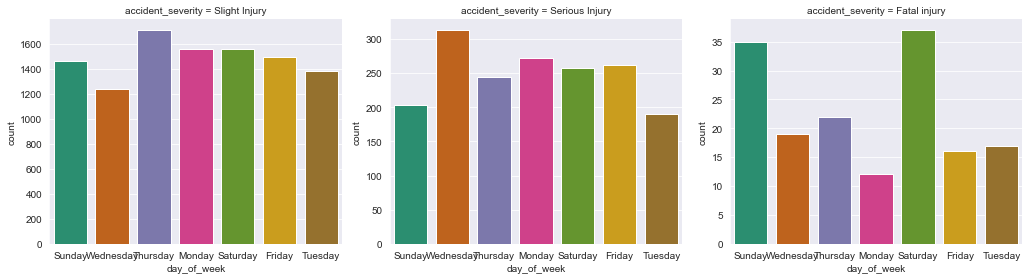

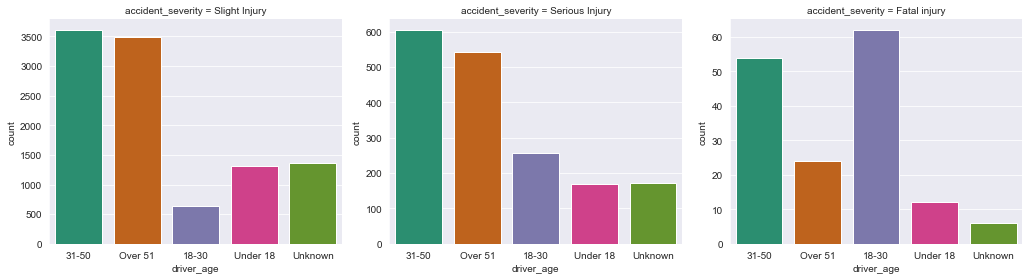

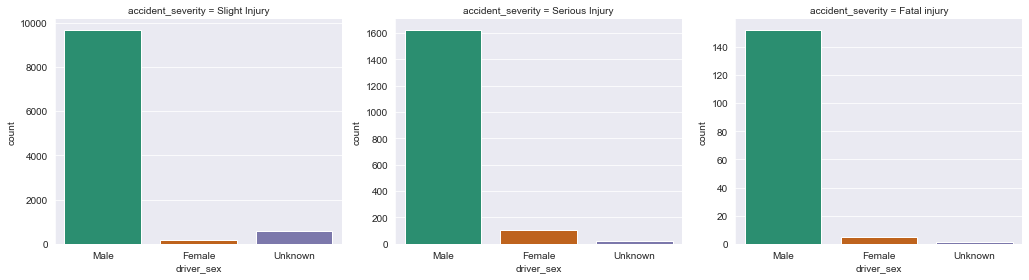

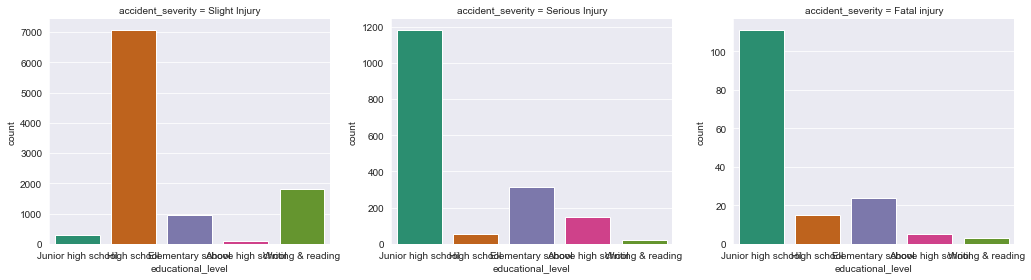

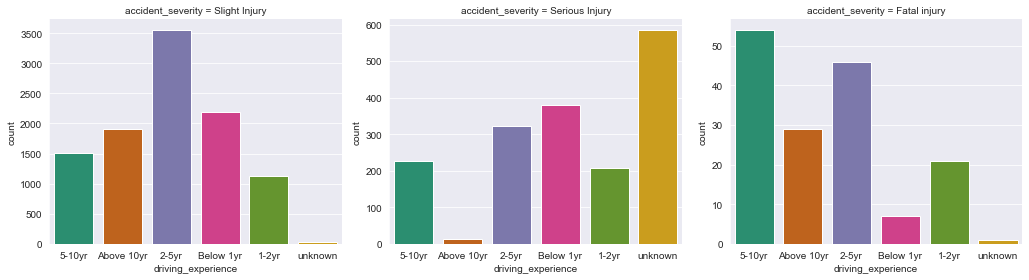

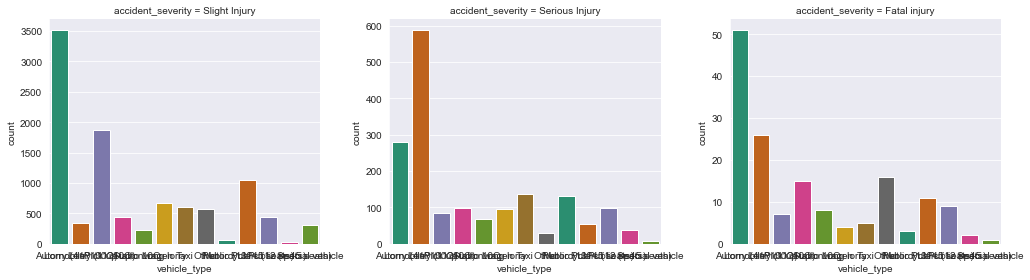

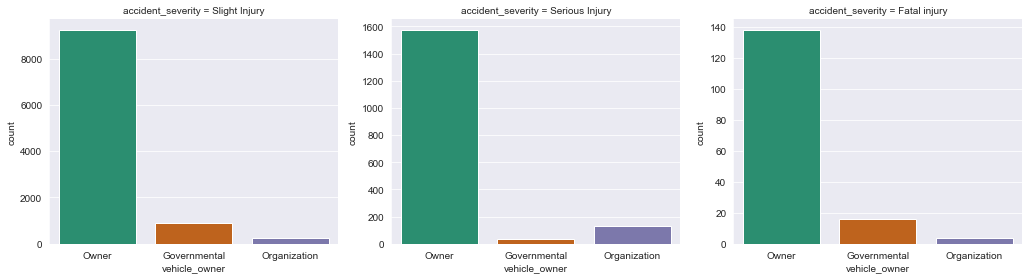

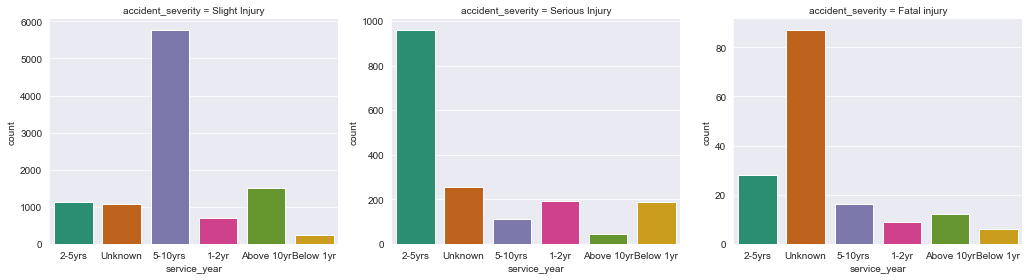

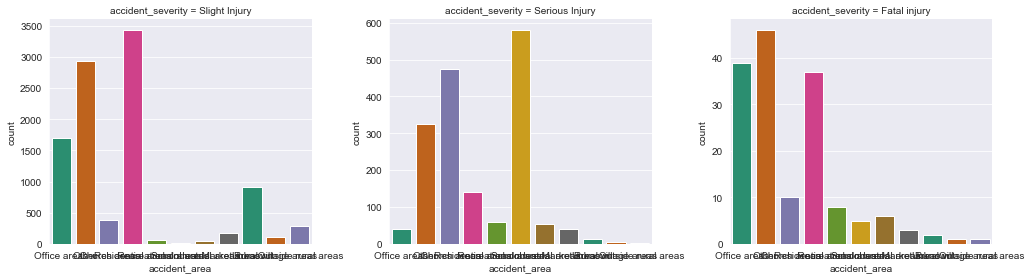

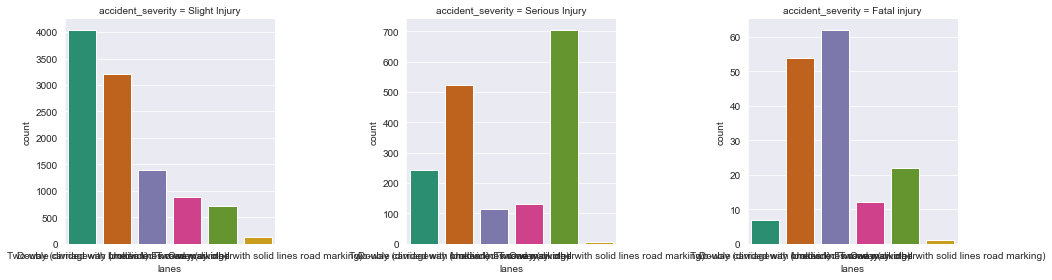

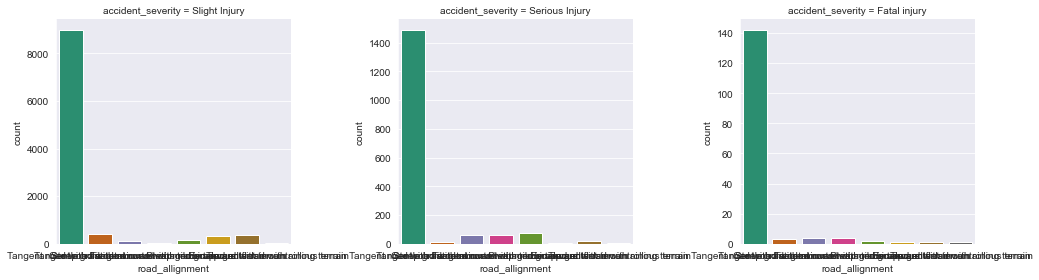

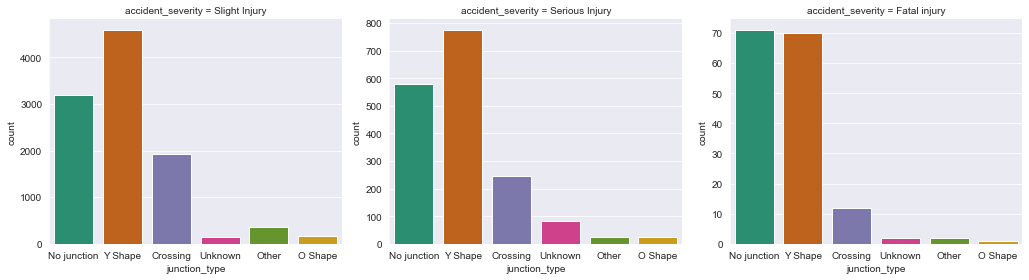

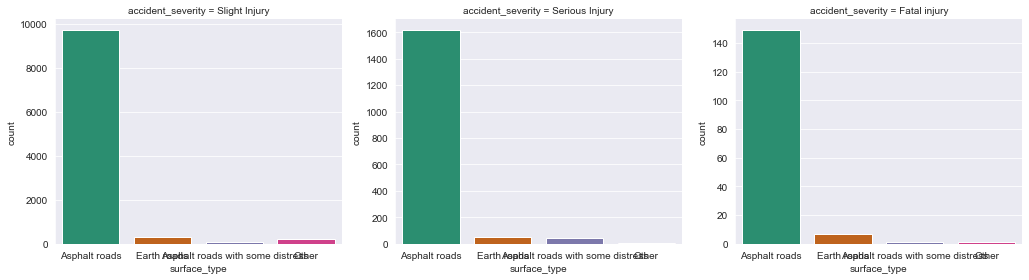

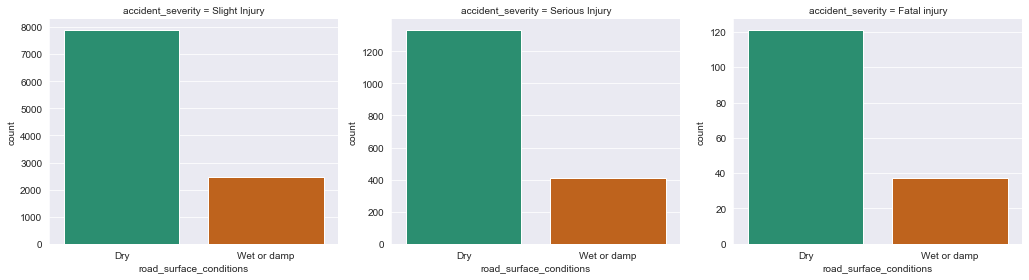

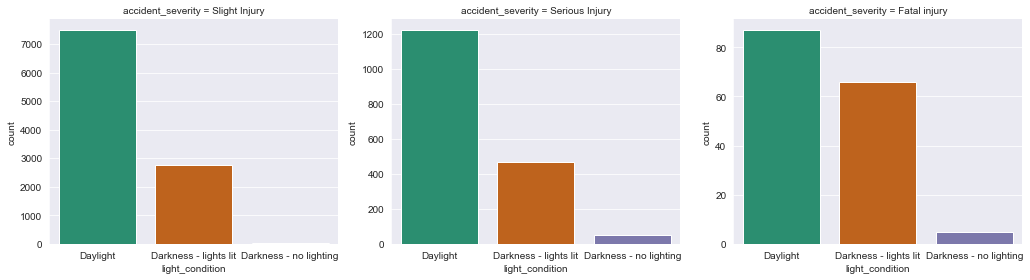

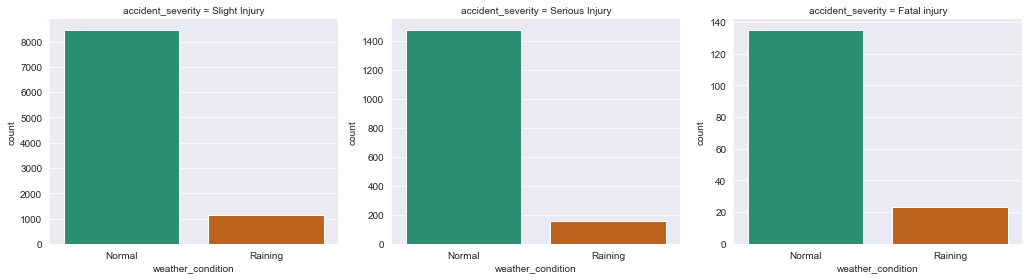

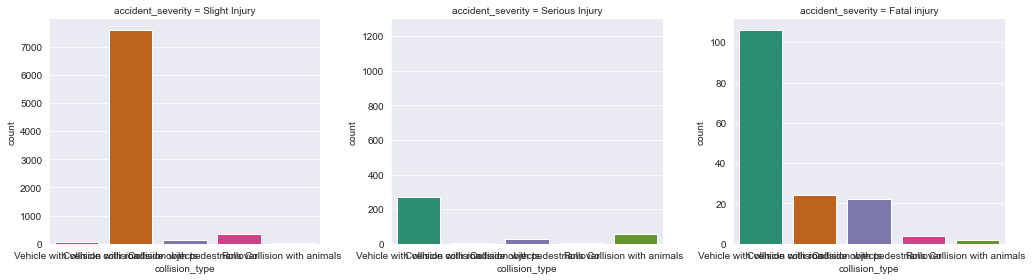

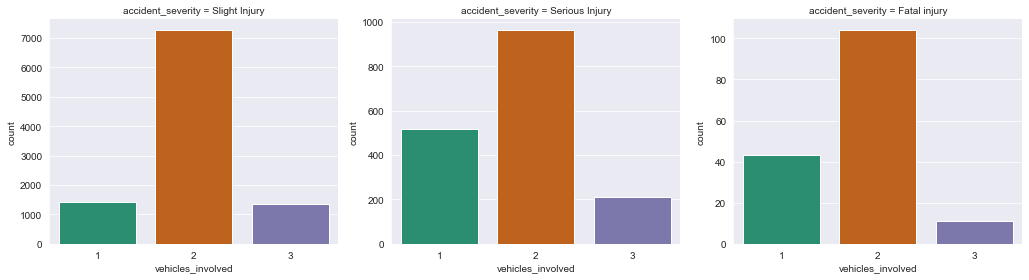

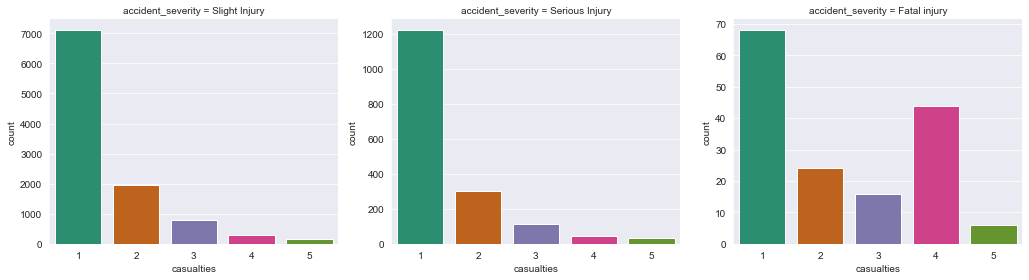

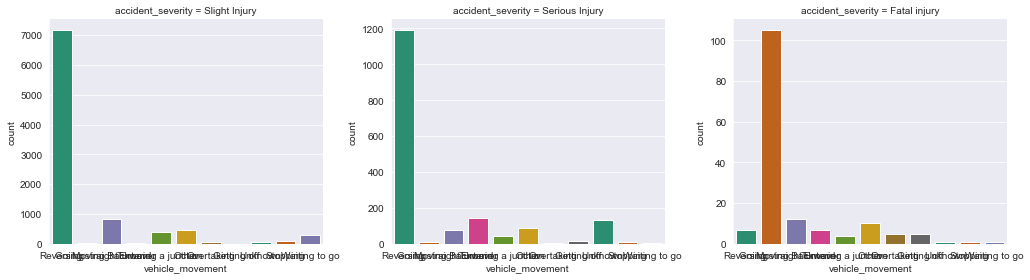

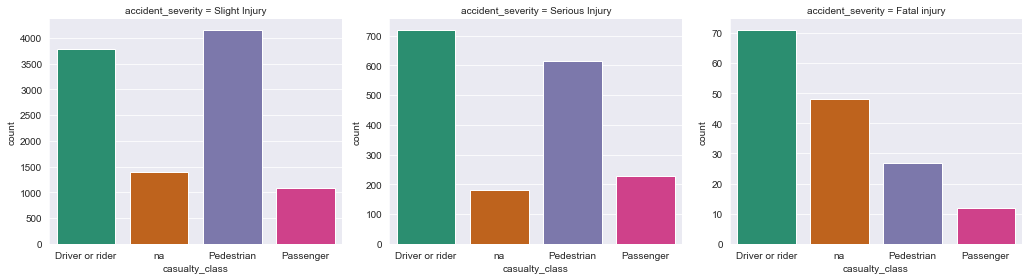

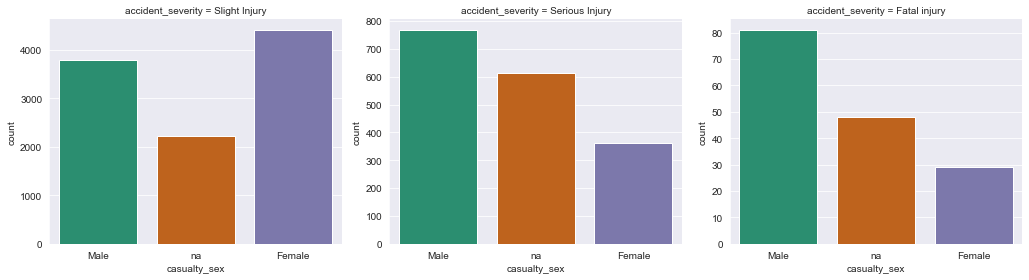

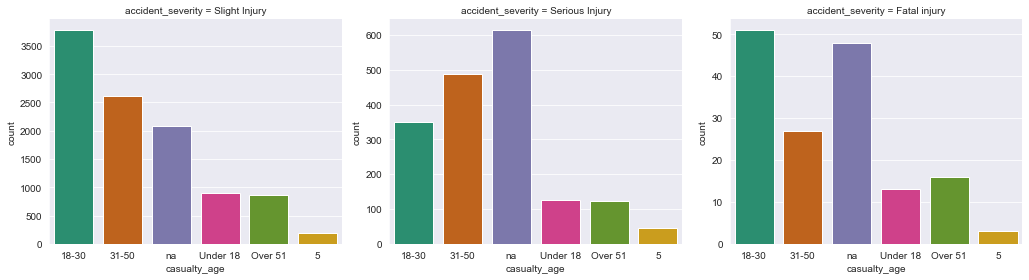

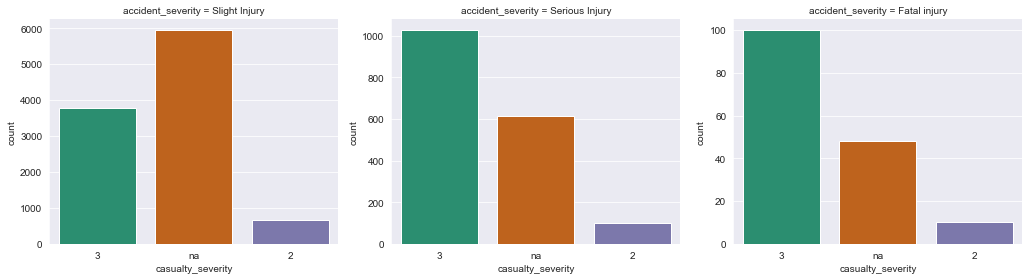

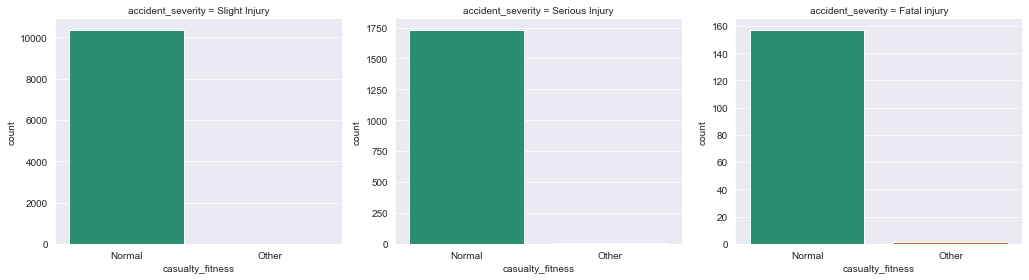

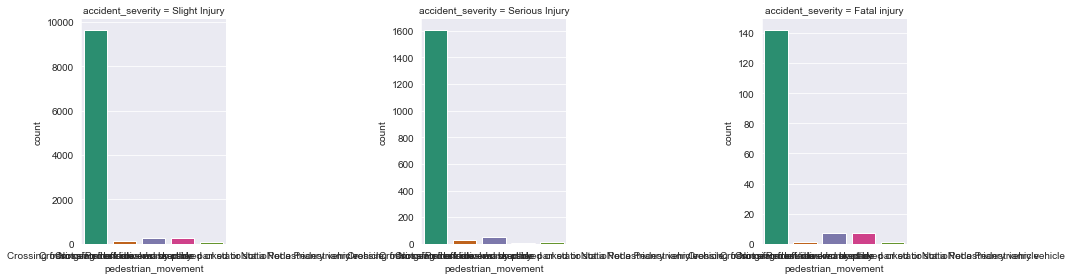

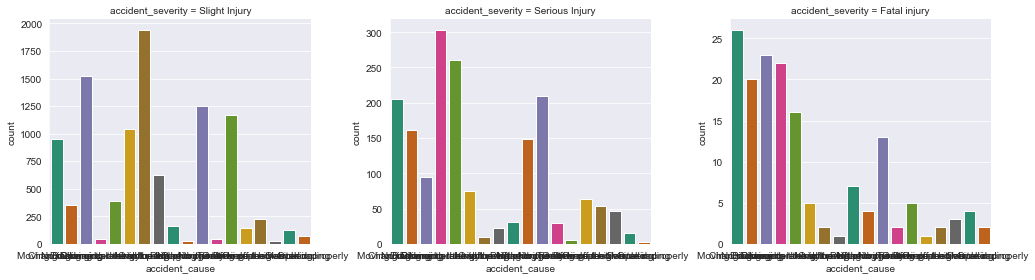

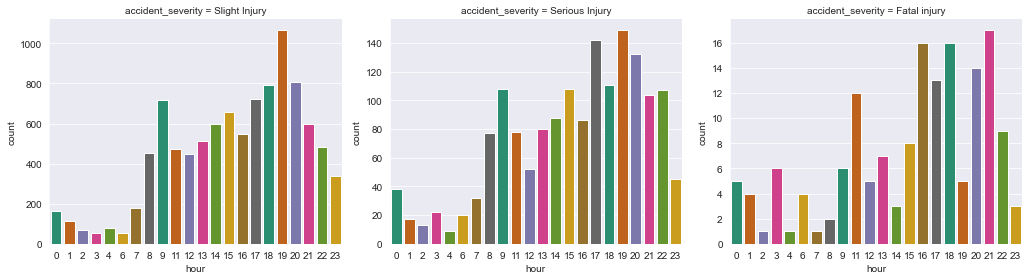

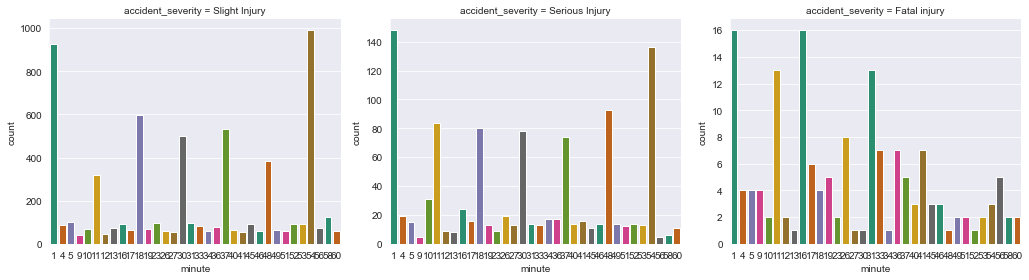

In [36]:
for col in df_rta.drop('accident_severity', axis=1):
    g = sns.FacetGrid(df_rta, col='accident_severity', size=4, aspect=1.2, sharey=False)
    g.map(sns.countplot, col, palette = 'Dark2')
    plt.show()

## Preprocessing and Modelling

In [37]:
X = df_rta.drop('accident_severity', axis=1)
y = df_rta["accident_severity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42)

print("X_train is :", X_train.shape)
print("X_test is :", X_test.shape)
print("y_train is :", y_train.shape)
print("y_test is :", y_test.shape)

X_train is : (8621, 29)
X_test is : (3695, 29)
y_train is : (8621,)
y_test is : (3695,)


<AxesSubplot:>

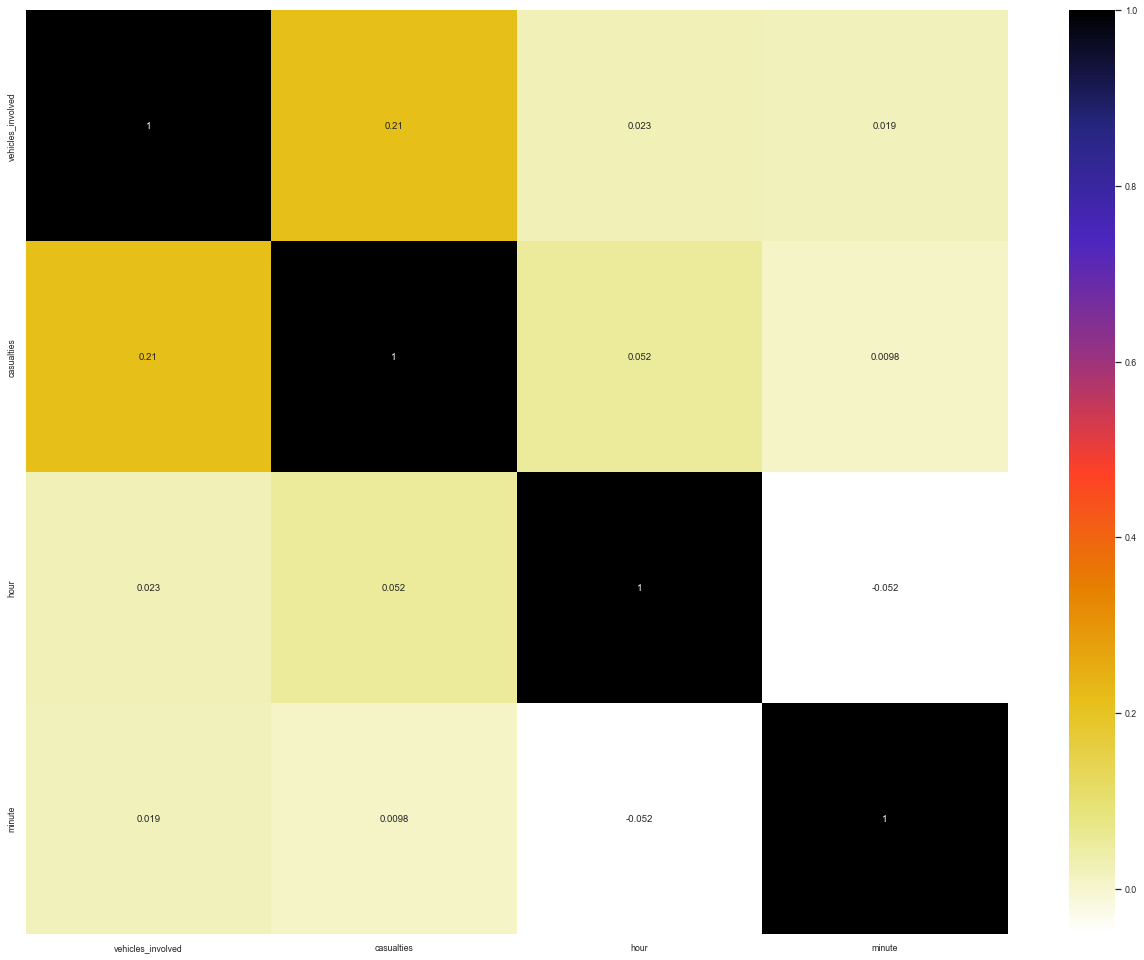

In [38]:
## Plot the covariance 
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(df_rta.corr(), annot=True, cmap=plt.cm.CMRmap_r)

## Upsampling

In [39]:
X = df_rta.drop("accident_severity", axis=1)
y = df_rta["accident_severity"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 29) (3695, 29) (8621,) (3695,)


In [40]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vehicles_involved,8621.0,2.044310,0.690764,1.0,2.0,2.0,2.0,7.0
casualties,8621.0,1.536945,0.989591,1.0,1.0,1.0,2.0,8.0
hour,8621.0,13.837258,5.192899,0.0,10.0,15.0,18.0,23.0
minute,8621.0,28.578239,17.483875,1.0,13.0,31.0,44.0,60.0


<AxesSubplot:>

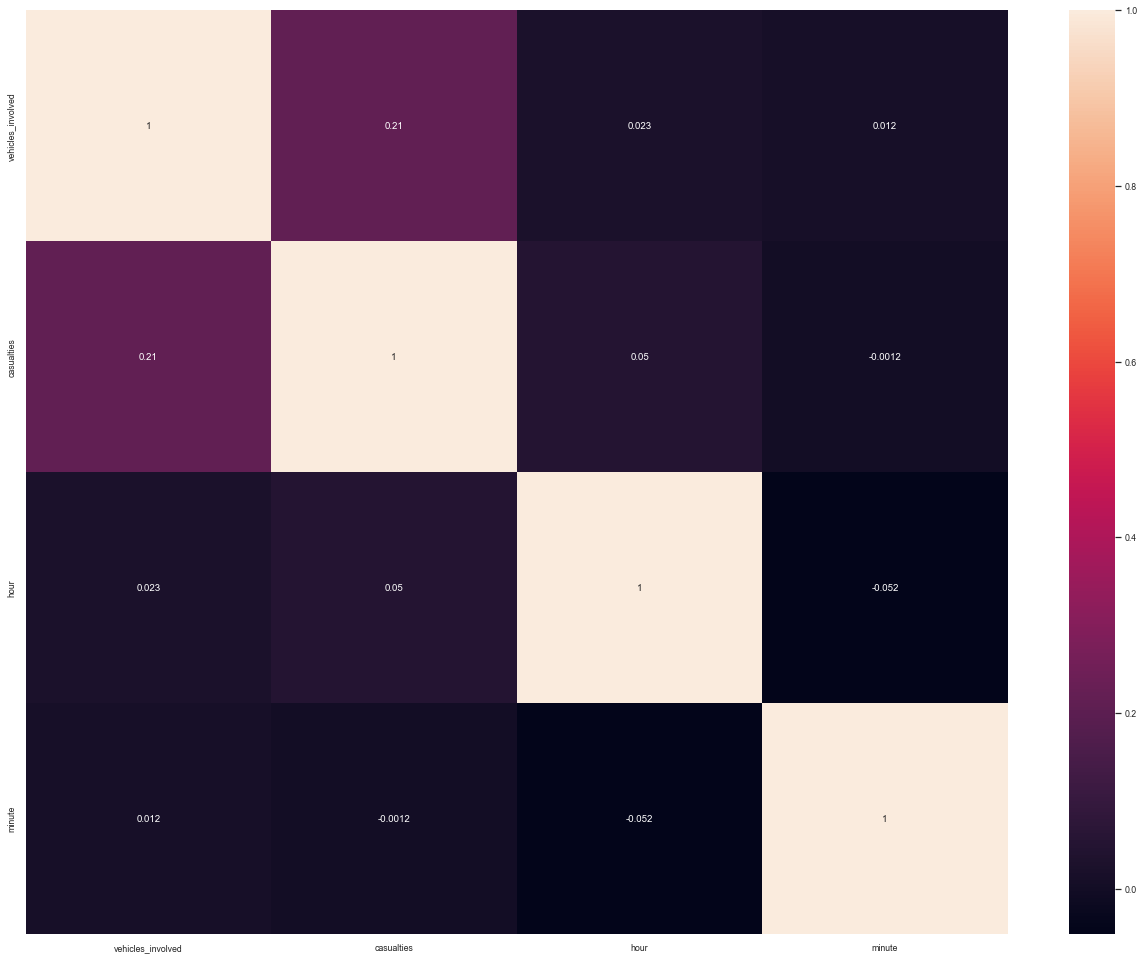

In [41]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(X_train.corr(), annot=True)

In [42]:
# upsampling using smote

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Slight Injury, n=7324 (84.96%)
Class= Serious Injury, n=1191 (13.82%)
Class= Fatal injury, n=106 (1.23%)


ValueError: could not convert string to float: 'Wednesday'

In [45]:
! pip install streamlit

  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached tzlocal-4.1-py3-none-any.whl (19 kB)


  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)


In [46]:
import streamlit as st